# Trabalho Final

Importando as bibliotecas que serão usadas

In [1]:
# Util
import operator
import math
import random
import numpy as np
from numpy import linspace, sin, pi, int16
import matplotlib.pyplot as plt
%matplotlib inline

# Genetic Programming
from deap import algorithms
from deap import base
from deap import creator
from deap import tools
from deap import gp

import librosa
import librosa.display
from IPython.display import Audio

import warnings; warnings.simplefilter('ignore')

Carregando o som desejado

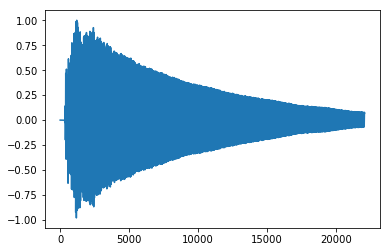

In [2]:
f0 = 440.0
#target, sr = librosa.load('SOUNDS/au_sample.wav')
#target, sr = librosa.load('SOUNDS/flute.wav')
target, sr = librosa.load('SOUNDS/harp.wav')
#target, sr = librosa.load('SOUNDS/string.wav')
target = librosa.util.normalize(target[:sr]) # normalizando etruncando para 1 segundo
duration = 1.0
plt.plot(target)
Audio(target,rate=sr)

In [3]:
# FUNCOES OPERADORES
def note(freq, amp=1.0):
    t = linspace(0,1.0,1.0*22050)
    data = sin(2.0*pi*freq*t)*amp
    return data

def fm(c_amp,c_freq, note_mod):
    t = linspace(0,1.0,1.0*22050)
    data = c_amp * sin(2.0*pi *(c_freq*t + note_mod))
    return data


In [4]:
def evaluate(individual):
    func = toolbox.compile(expr=individual)
    candidate = librosa.util.normalize(func(f0))
    
    candidate_mag = librosa.util.normalize(np.abs(librosa.stft(candidate)), axis=1)
    candidate_pha = librosa.util.normalize(np.angle(librosa.stft(candidate)), axis=1)
    
    target_mag = librosa.util.normalize(np.abs(librosa.stft(target)), axis=1)
    target_pha = librosa.util.normalize(np.angle(librosa.stft(target)), axis=1)
    
    mag_error = np.mean((candidate_mag - target_mag)**2)
    pha_error = np.mean((candidate_pha - target_pha)**2)
    
    return mag_error*0.7 + pha_error*0.3,

In [5]:
def evaluate_max(individual):
    func = toolbox.compile(expr=individual)
    candidate = librosa.util.normalize(func(f0))
    
    candidate_mag = np.abs(librosa.stft(candidate))
    candidate_pha = np.angle(librosa.stft(candidate))
    
    target_mag = np.abs(librosa.stft(target))
    target_pha = np.angle(librosa.stft(target))
    
    mag_error = np.max((candidate_mag - target_mag)**2)
    pha_error = np.max((candidate_pha - target_pha)**2)
    
    return (mag_error*0.7 + pha_error*0.3),

In [6]:
# PROGRAMAÇÂO GENETICA
pset = gp.PrimitiveSetTyped("MAIN", [float], np.ndarray, "F")

# OPERATORS
pset.addPrimitive(note, [float, float], np.ndarray)
pset.addPrimitive(operator.add,[np.ndarray,np.ndarray],np.ndarray)
pset.addPrimitive(operator.sub,[np.ndarray,np.ndarray],np.ndarray)
pset.addPrimitive(operator.mul,[np.ndarray,np.ndarray],np.ndarray)
pset.addPrimitive(fm, [float,float,np.ndarray], np.ndarray)
pset.addPrimitive(operator.add,[float,float],float)
# pset.addPrimitive(gen_cos, [float,float], list)

# TERMINALS
# if not scoop.IS_ORIGIN:
#    pset.addEphemeralConstant("rand100", lambda: random.random() * 100, float)
pset.addEphemeralConstant("rand100", lambda: random.random() * 100, float)
pset.addEphemeralConstant("rand101", lambda: random.randint(-1,1), float)
pset.addTerminal(note(0), np.ndarray, 'zero')
pset.addTerminal(note(f0), np.ndarray, 'fundamental')
#pset.addTerminal(note(2*f0), np.ndarray, 'harm1')
#pset.addTerminal(note(3*f0), np.ndarray, 'harm2')
#pset.addTerminal(note(4*f0), np.ndarray, 'harm3')
pset.addTerminal(f0, float)
#pset.addTerminal(2*f0, float)
#pset.addTerminal(3*f0, float)
#pset.addTerminal(4*f0, float)

# CONFIG
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", gp.PrimitiveTree, fitness=creator.FitnessMin)

toolbox = base.Toolbox()
# toolbox.register("map", futures.map)
toolbox.register("expr", gp.genHalfAndHalf, pset=pset, min_=1, max_=2)
toolbox.register("individual", tools.initIterate, creator.Individual, toolbox.expr)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
toolbox.register("compile", gp.compile, pset=pset)

toolbox.register("evaluate", evaluate_max)
toolbox.register("select", tools.selTournament, tournsize=3)
toolbox.register("mate", gp.cxOnePoint)
toolbox.register("expr_mut", gp.genFull, min_=0, max_=2)
toolbox.register("mutate", gp.mutUniform, expr=toolbox.expr_mut, pset=pset)

toolbox.decorate("mate", gp.staticLimit(key=operator.attrgetter("height"), max_value=10))
toolbox.decorate("mutate", gp.staticLimit(key=operator.attrgetter("height"), max_value=10))

In [7]:
def main():
    random.seed(17) #VALOR UTILIZADO 10
    pop = toolbox.population(n=20000)
    hof = tools.HallOfFame(1)
    stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats.register("avg", np.mean)
    stats.register("std", np.std)
    stats.register("min", np.min)
    stats.register("max", np.max)

    algorithms.eaSimple(pop, toolbox, 0.75, 0.2, 100, stats, halloffame=hof)

    return pop, stats, hof

In [8]:
pop, stats, hof = main()

gen	nevals	avg   	std   	min    	max   
0  	20000 	159053	131048	23367.9	733303
1  	16006 	123168	84699.4	14836  	732113
2  	15923 	106542	77814.2	14836  	732422
3  	16192 	87724 	63172.5	14836  	731804
4  	16141 	74391.1	52233.8	14836  	731215
5  	16089 	68667.8	47324.9	14836  	725219
6  	16106 	64959.7	49073  	14836  	729499
7  	15888 	60425.1	44005.7	14836  	724989
8  	16037 	56624  	42873.9	14836  	732901
9  	15865 	53878.4	43718  	13859.2	724989
10 	16078 	52627  	44180.5	13859.2	724989
11 	16040 	51148.5	43469.1	13042.2	728524
12 	15941 	49064.8	40092.2	13042.2	724989
13 	16011 	47254  	37134.8	13042.2	724989
14 	16057 	46185.8	37505.4	13042.2	724989
15 	16056 	45264.2	35884.3	13042.2	730936
16 	16043 	43892  	38010.9	13042.2	724989
17 	15986 	43140.8	36460.2	12357.4	724989
18 	16047 	43020.9	39029.7	12357.4	724989
19 	15746 	41591.4	39622.2	12357.4	724989
20 	16048 	41254.5	43876.5	10939.5	724989
21 	15980 	40097.4	45426.8	10536  	724989
22 	16087 	40323.7	57501.3	10236.3	728309

In [9]:
str(hof[0])

'sub(sub(fm(440.0, 440.0, zero), fm(66.6623102439641, F0, fundamental)), mul(add(note(-1, add(440.0, add(-1, -1))), fm(F0, add(-1, add(0, -1)), fm(-1, add(1, 10.332683179516389), add(mul(fundamental, mul(add(zero, fundamental), fundamental)), mul(fundamental, fundamental))))), fundamental))'

In [10]:
func = toolbox.compile(hof[0])
candidate = librosa.util.normalize(func(f0))
Audio(candidate,rate=sr)

In [12]:
librosa.output.write_wav('SOUNDS/gen_harp2.wav',candidate,sr)

In [13]:
def print_signals(target,candidate):
    plt.figure(1,figsize=(15, 9))
    plt.subplot(221)
    plt.plot(target)
    
    plt.subplot(222)
    plt.plot(candidate)
    
    plt.subplot(223)
    D_target = librosa.amplitude_to_db(librosa.stft(target), ref=np.max)
    librosa.display.specshow(D_target, y_axis='log')
    plt.colorbar(format='%+2.0f dB')
    plt.title('TARGET')
    
    plt.subplot(224)
    D_candidate = librosa.amplitude_to_db(librosa.stft(candidate), ref=np.max)
    librosa.display.specshow(D_candidate, y_axis='log')
    plt.colorbar(format='%+2.0f dB')
    plt.title('CANDIDATE')

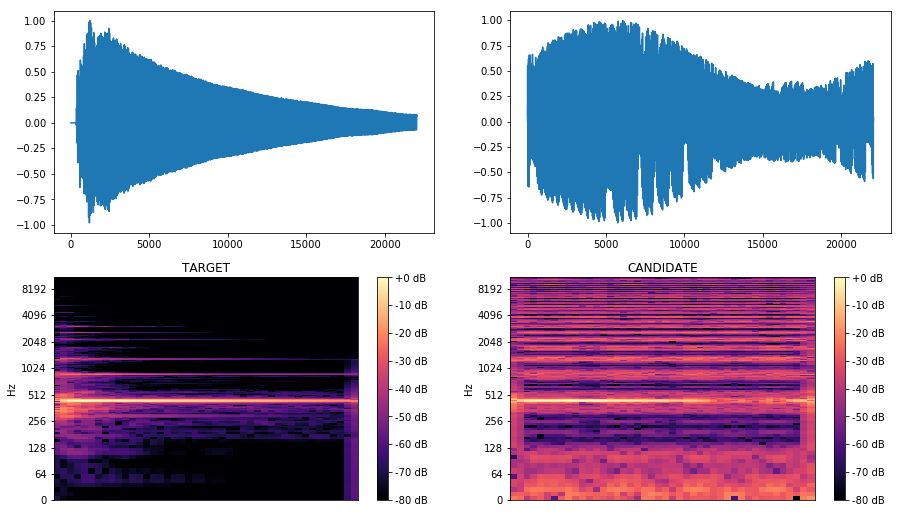

In [14]:
print_signals(target,candidate)